# Basic Analysis of Xenium Data 
#### **Prerequisites:**
- Preprocessed, segmented, & cell typed Xenium dataset saved as in AnnData format
- A virtual enviroment (eg conda environment) with the necessary python packages (below) installed

In [1]:
import ast
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
import warnings
import json
import sys
import os
import anndata as ad

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn import neighbors

For this workflow, I will be using the **10X Xenium Colon** dataset (avaliable [here](https://www.10xgenomics.com/datasets/human-colon-preview-data-xenium-human-colon-gene-expression-panel-1-standard)) that is used in the Segger paper (Heidari, Moorman et al. [*bioRxiv*](https://www.biorxiv.org/content/10.1101/2025.03.14.643160v1) 2025, [GitHub](https://github.com/dpeerlab/segger-analysis/)). Specifically, I will be using a version with cell segmentation.

## Preliminary visualizations
Depending on how you preprocessed your data, you should have saved the position of each cell. This may be in adata.obs as a column for the X location and a column for the Y position, or it may already be saved as an array in adata.obsm. You can use these position to visualize information, such as cell type, in the original spatial context. This dataset only contains one Xenium run, but, if you have multiple slides in one dataset, remember to split your adata object before visualizing otherwise you will likely end up with overlapping tissues.  

In [2]:
## Load Anndata
filepath_ad = '/data/peer/adamsj5/spatial_celltypist/data_spatial/10x_colon_cell_celltyped.h5ad' #replace with your file path
adata = sc.read_h5ad(filepath_ad)

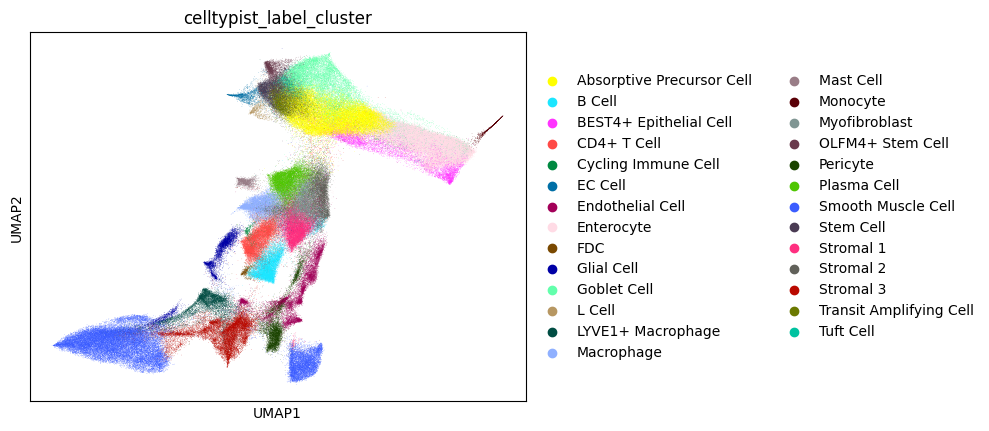

In [3]:
sc.pl.umap(adata, color = 'celltypist_label_cluster')

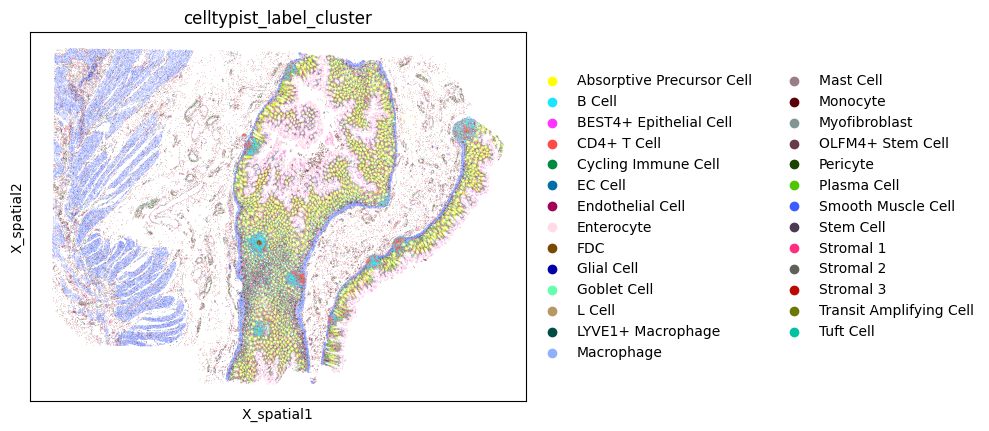

In [4]:
sc.pl.embedding(adata, basis='X_spatial', color='celltypist_label_cluster')

This allows you to see the spatial organization of the cell types in the tissue. You can also use phenograph or leiden clusters. 

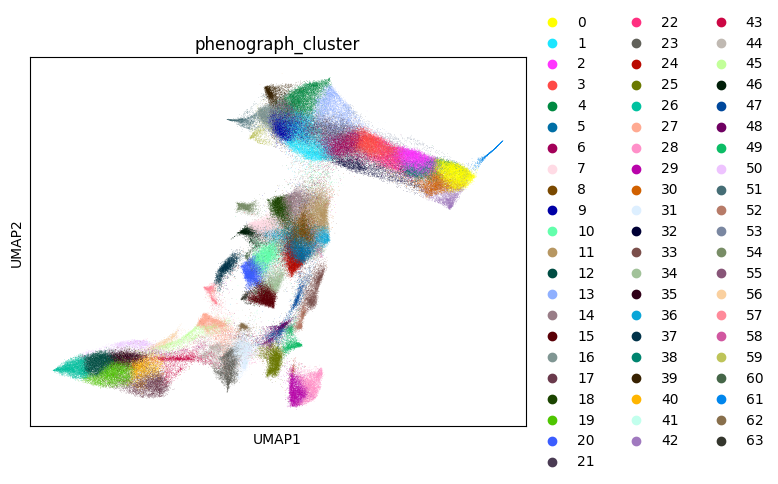

In [5]:
sc.pl.umap(adata, color = 'phenograph_cluster')

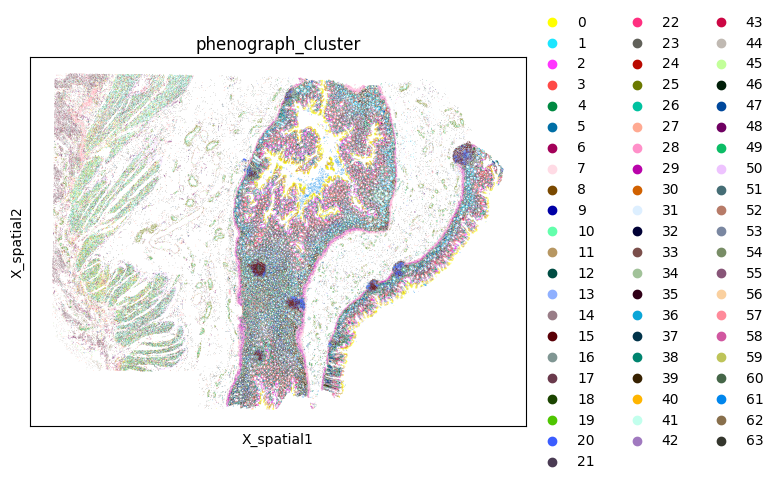

In [6]:
sc.pl.embedding(adata, basis='X_spatial', color='phenograph_cluster')

If you have a more coarse cell type labels, that may also make visualizing the data spatially a little simpler, and may highlight structures of intrest more easily.

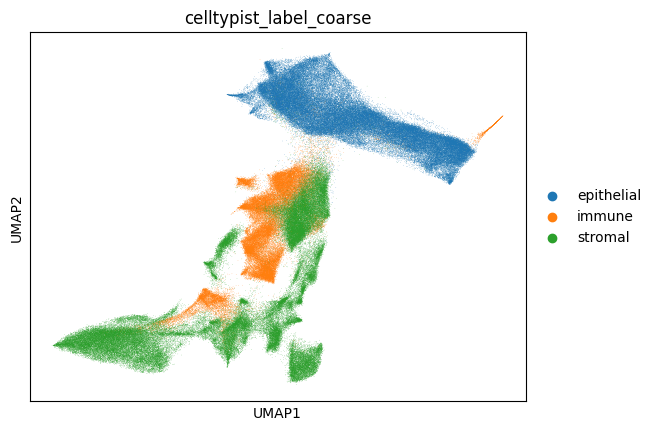

In [7]:
sc.pl.umap(adata, color = 'celltypist_label_coarse')

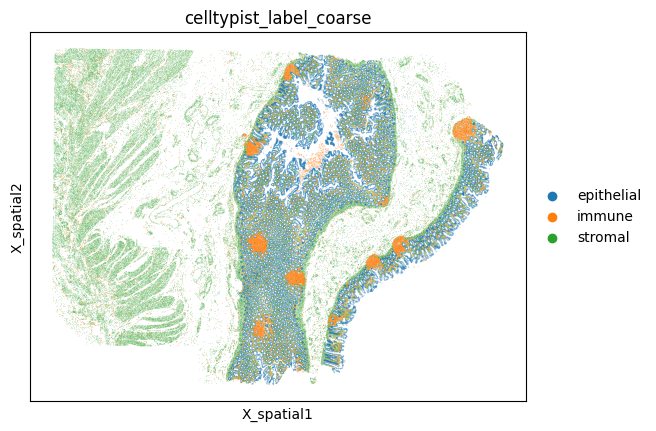

In [8]:
sc.pl.embedding(adata, basis='X_spatial', color='celltypist_label_coarse')

There are many scRNA-seq analysis approaches, such as diffusion components, that you could run on the gene expression data from Xenium. While you should be wary that they were optimized to work on datasets with more genes and less sparsity, they could still provide insights into the data and could also be visualized in this spatial representation. 

## Niches 
The interesting part of spatial transcriptomics data comes from the combination of gene expression data and spatial context, which thus far we've largely treated as seperate entities. However, the most interesting analysis will come from integrating these two data types. Fundamentally, we are interested in a cell's microenvironment, or the area & cells immediately surrounding a cell of interest, as this is the space that is likely impacting that cell's phenotype, gene expression, morphology, etc the most. Computationally, we represent this microenvironment as a niche and this next portion will walk you through how to compute and work with these niches. 

### Construction
A common way to compute a cell's niche is using a k-Nearest Neighbors (kNN) algorithm. For this data, kNN works by calculating the distance between every cell in space (using the cell’s position in the tissue) and, for each cell, determines which k cells have the smallest distance to the cell of interest. This information is usually displayed as a neighbors graph where each cell is a node and nodes are connected to their k nearest neighbors. This framework fits well with defining microenvironments based on spatial location. The cell that a kNN graph (or niche) is constructed around is called the anchor cell.

The nice thing in using a kNN graph to define niches is that it is flexible to different sizes of niche since you can set k to be whatever value you would like. Additionally, sklearn (the Python package we will use for defining this graph) has different methodologies you can use for defining your neighborhoods. First, is a classic kNN graph where you set the number of cells you want every niche to have. This will keep niche sizes consistent and allow for easy comparisons across niches. However, if you would like to take the density of your tissue into account, you can use a radius graph instead. This operates similarly to a kNN graph, except instead of defining neighbors by the nearest k, you set a limit on how far from the anchor cell you want to look. This means for densely packed tissues where there are many cells close together, the niches will be bigger, and for more open tissue where there is more space, there will be fewer cells in each niche. Which method you choose is up to you and the biological questions you are most interested in. For this workflow, we will keep things simple and use the classic kNN method.

Additionally, you can create these kNN graphs to either contain or exclude the anchor cell. If you are interested only in the niche, then leave out the anchor cell, otherwise keep it in the graph.

Finally, the last thing to be mindful of is whether your data contains one or more Xenium slides. If it is just one, everything is simple. However, if you have multiple slides saved in the same dataset, you will need to calculate niches on each slide independently. This is because the positions of the different slides may be overlapping and you could include cells from multiple tissues in your niches, which is biologically meaningless.

The functions below will help you compute niche matricies on spatial data. They require: 
- `spatial_data`: the AnnData object that holds the gene expression data and spatial information from the Xenium experiment you are analyzing 
- `spatial_key`: specifications of where each cell is in the tissue. should be saved in `spatial_data.obsm`
- `batch_key`: if there is more than one slide in your data, this is a column in `spatial_data.obs` that specificies which slide each cell comes from 
- `inp_type`: which version of the data to use. Aka counts saved in `spatial_data.X`, log normalized saved in `spatial_data.layers["scaled_log"]`, or PCs (or something else) saved in `spatial_data.obsm`.
- `graph_type`: whether to use a kNN or radius approach in calculating niches (default: kNN)
- `kNN`: *ignore if graph type is not kNN* value of k to use when computing kNN graphs (default: 8)
- `r`: *ignore if graph_type is kNN'* radius value to use when computing (default: 20)
- `include_self`: whether or not to include the anchor cell in the niche (default: True)

It will output: 
- `NicheMats`: An array of arrays where each nested array (which is also an array) contains the gene expression of all the cells in each niche. 
- `kNNGraphIndex`: An array of arrays where each nested array contains the indicies of the cells in that niche. It is in the same order as `NicheMats`

In [9]:
def BatchKNN(data, batch, graph_type ='kNN', kNN=8, r=20, include_self=True):
    """
    Internally, Computes k-nearest neighbors for data points, respecting batch boundaries.
    """
    
    kNNGraphIndex = np.zeros(shape=(data.shape[0], k))

    for val in np.unique(batch):
        val_ind = np.where(batch == val)[0]
        
        
        if graph_type == 'kNN':
            batch_knn = sklearn.neighbors.kneighbors_graph(
                spatial_data.obsm[spatial_key],
                n_neighbors=kNN,
                mode="connectivity",
                n_jobs=-1,
                include_self=include_self
            ).tocoo()
        else:
            batch_knn = sklearn.neighbors.radius_neighbors_graph(
                spatial_data.obsm[spatial_key],
                radius=r, 
                mode='distance', 
                n_jobs=-1, 
                include_self=include_self
            ).tocoo()
            
        batch_knn_ind = np.reshape(
            np.asarray(batch_knn.col), [data[val_ind].shape[0], k]
        )
        kNNGraphIndex[val_ind] = val_ind[batch_knn_ind]

    return kNNGraphIndex.astype("int")

def CalcNicheMats(spatial_data, spatial_key="X_spatial", batch_key=-1, inp_type="X", graph_type ='kNN', kNN=8, r=20, include_self=True):

    if inp_type != "X":
        ExpData = spatial_data.obsm[inp_type]
    elif inp_type == "log":
        ExpData = spatial_data.layers["scaled_log"] # constructed using scaled log data
    else:
        ExpData = spatial_data.X

    if batch_key == -1: # if no batches
        if graph_type == 'kNN':
            kNNGraph = sklearn.neighbors.kneighbors_graph(
                spatial_data.obsm[spatial_key],
                n_neighbors=kNN,
                mode="connectivity",
                n_jobs=-1,
                include_self=include_self
            ).tocoo()
        else:
            kNNGraph = sklearn.neighbors.radius_neighbors_graph(
                spatial_data.obsm[spatial_key],
                radius=r, 
                mode='distance', 
                n_jobs=-1, 
                include_self=include_self
            ).tocoo()
            
        kNNGraphIndex = np.reshape(
            np.asarray(kNNGraph.col), [spatial_data.obsm[spatial_key].shape[0], kNN]
        )
    else: # if there are batches
        kNNGraphIndex = BatchKNN(
            spatial_data.obsm[spatial_key], spatial_data.obs[batch_key], kNN
        )

    NicheMats = (
        ExpData[kNNGraphIndex[np.arange(ExpData.shape[0])]]
    )
    
    return NicheMats, kNNGraphIndex

This function is expecting data to be in a certain format. If your counts are saved in a csc or csr format, you will need to change it to a dense format. 

In [10]:
adata.X = adata.X.todense()

/data/peer/adamsj5/tools/miniconda3/envs/celltyping/lib/python3.10/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)


In [11]:
NicheMats, kNNGraphIndex = CalcNicheMats(adata, spatial_key="X_spatial", inp_type="X", graph_type ='kNN', kNN=8,include_self=True)

It is helpful to know some information about cells in each niche, such as cell types. Here is a function on how to get cell type information across each niche.

In [12]:
def neighbor_cell_type_counts(adata, knn_indices, cell_type_column='celltypist_label_cluster'):
    # Convert cell types to categorical for consistent column ordering
    cell_types = adata.obs[cell_type_column].astype('category')
    cell_type_categories = cell_types.cat.categories
    
    # Prepare an empty DataFrame for counts
    counts_df = pd.DataFrame(0, index=adata.obs.index, columns=cell_type_categories, dtype=int)
    
    # Wrap the loop in tqdm for progress tracking
    for i, neighbors in tqdm(list(enumerate(knn_indices)), total=len(knn_indices), desc="Counting cell types"):
        neighbor_cell_types = cell_types.iloc[neighbors]
        cell_type_counts = neighbor_cell_types.value_counts()
        counts_df.iloc[i, counts_df.columns.get_indexer(cell_type_counts.index)] = cell_type_counts.values

    return counts_df

In [13]:
counts_df = neighbor_cell_type_counts(adata, kNNGraphIndex)

Counting cell types: 100%|██████████| 260232/260232 [01:47<00:00, 2420.77it/s]


### Visualization
There are many ways to visualize information about the niches. Since we have cell type information, we will focus on that here. For each cell type, you can visualize the average cell type composition of niches. 

In [15]:
proportions_df = counts_df.div(counts_df.sum(axis=1), axis=0)
anchor_cell_types = adata.obs['celltypist_label_cluster'].astype('category')
avg_niche_composition = proportions_df.groupby(anchor_cell_types).mean()

/tmp/ipykernel_68659/2647553090.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_niche_composition = proportions_df.groupby(anchor_cell_types).mean()


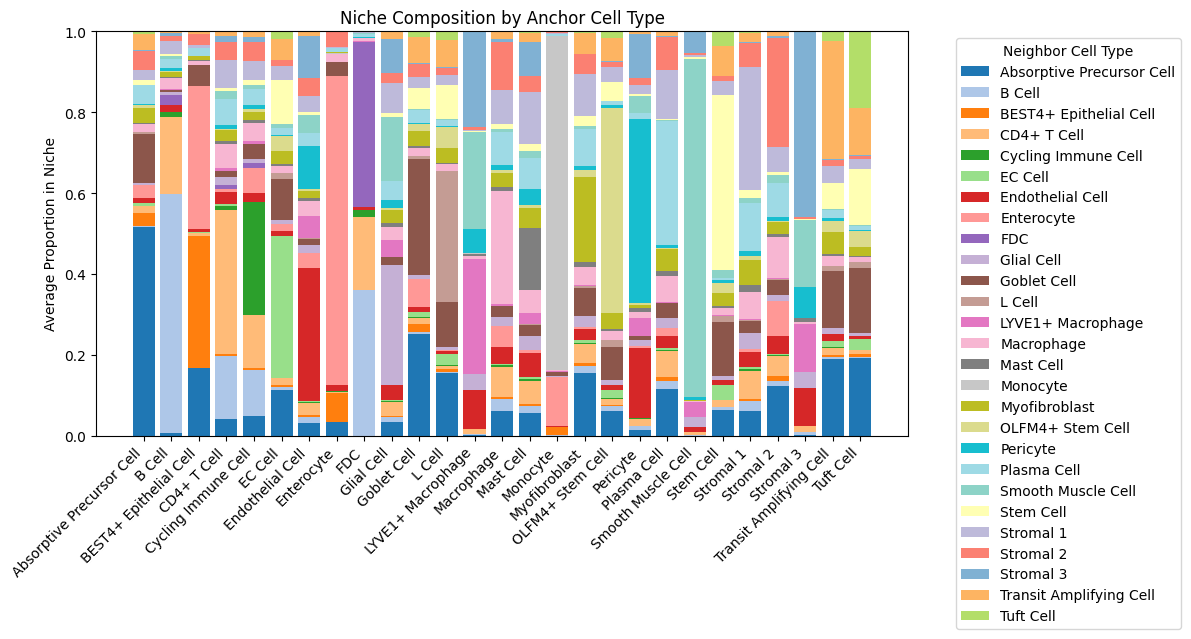

In [16]:
# get distinct colors for each cell type
cell_types = avg_niche_composition.columns
colors = sns.color_palette("tab20") + sns.color_palette("Set3", 7)
color_dict = dict(zip(cell_types, colors))

# Plot
plt.figure(figsize=(12, 6))
bottom = None
for col in cell_types:
    if bottom is None:
        p = plt.bar(avg_niche_composition.index, avg_niche_composition[col],
                    label=col, color=color_dict[col])
        bottom = avg_niche_composition[col].copy()
    else:
        p = plt.bar(avg_niche_composition.index, avg_niche_composition[col],
                    bottom=bottom, label=col, color=color_dict[col])
        bottom += avg_niche_composition[col]

plt.ylabel('Average Proportion in Niche')
plt.title('Niche Composition by Anchor Cell Type')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Neighbor Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()

You can also visualize this as a heatmap. 

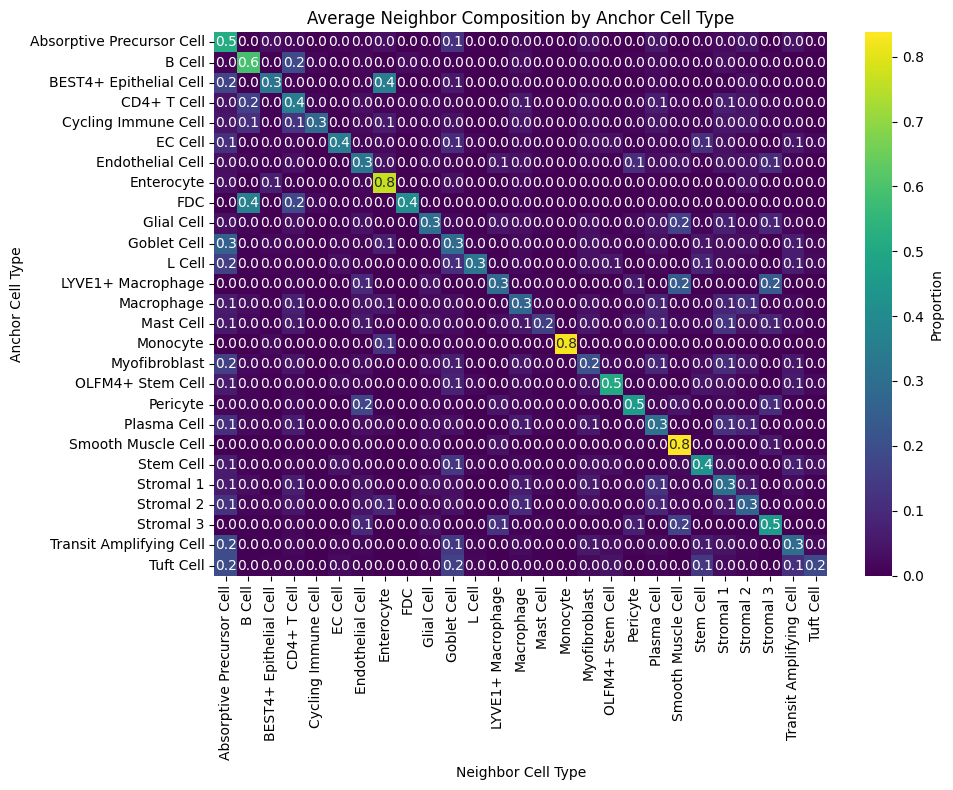

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(avg_niche_composition, cmap='viridis', annot=True, fmt=".1f", cbar_kws={'label': 'Proportion'})
plt.title('Average Neighbor Composition by Anchor Cell Type')
plt.xlabel('Neighbor Cell Type')
plt.ylabel('Anchor Cell Type')
plt.tight_layout()
plt.show()

 You can color both the GEX UMAP and spatial embedding by the most common cell type of each niche to see which cell types dominate which niches. 

In [18]:
max_cell_types = counts_df.idxmax(axis=1)
adata.obs['max_niche_cell_type'] = max_cell_types

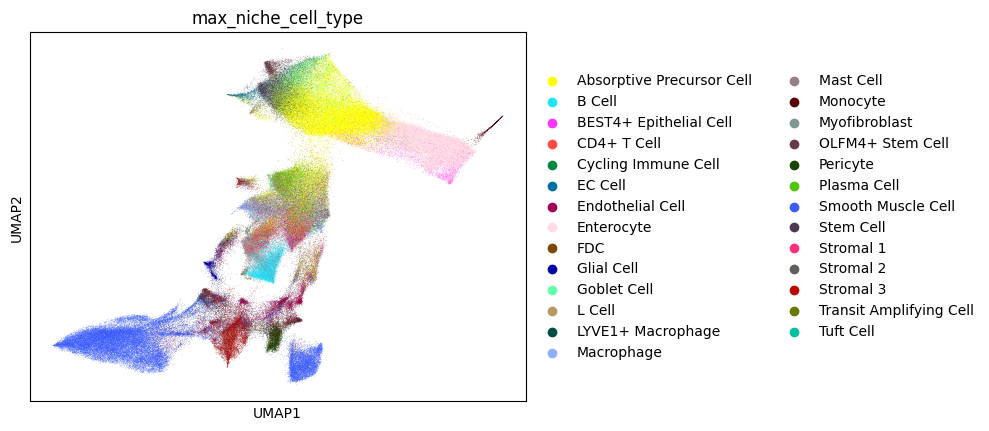

In [19]:
adata.uns['max_niche_cell_type_colors'] = adata.uns['celltypist_label_cluster_colors'].copy() #keep colours consistent
sc.pl.umap(adata, color = 'max_niche_cell_type')

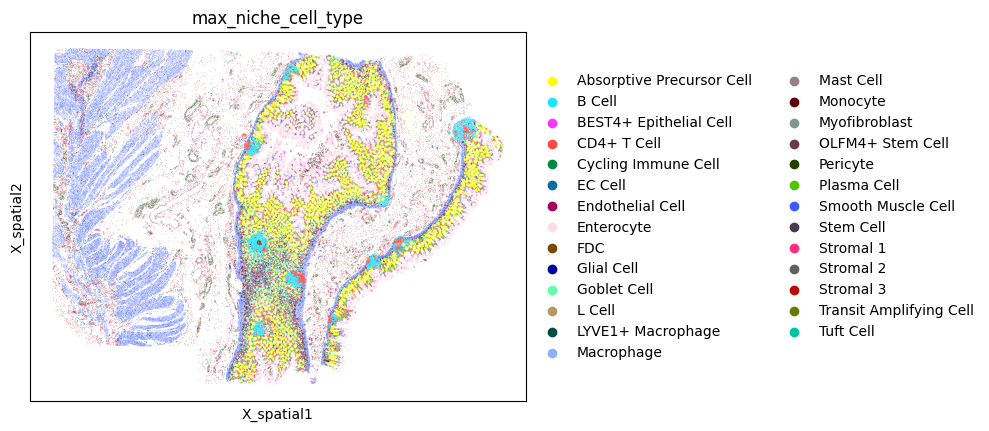

In [20]:
sc.pl.embedding(adata, basis = 'X_spatial', color='max_niche_cell_type')

Another way to look at cell type distributions in the niches is entropy. When we calculate entropy on the cell type proportions of the niches, it captures the diversity of cell types in that niche. A low entropy score means the niche is largely homogenous and a high entropy is more heterogenous. 

In [21]:
from scipy.stats import entropy

entropy_values = proportions_df.apply(lambda row: entropy(row.values, base=2), axis=1)
adata.obs['niche_entropy'] = entropy_values

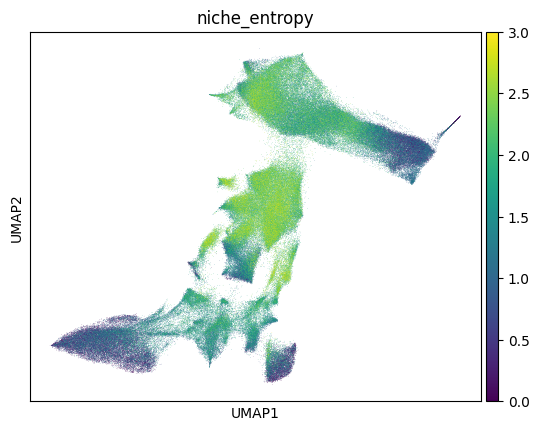

In [22]:
sc.pl.umap(adata,color = 'niche_entropy')

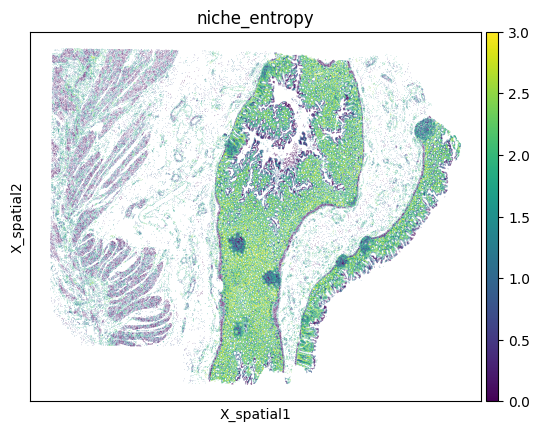

In [23]:
sc.pl.embedding(adata, basis = 'X_spatial', color = 'niche_entropy')

You can see which cell types have more diverse niches on average. 

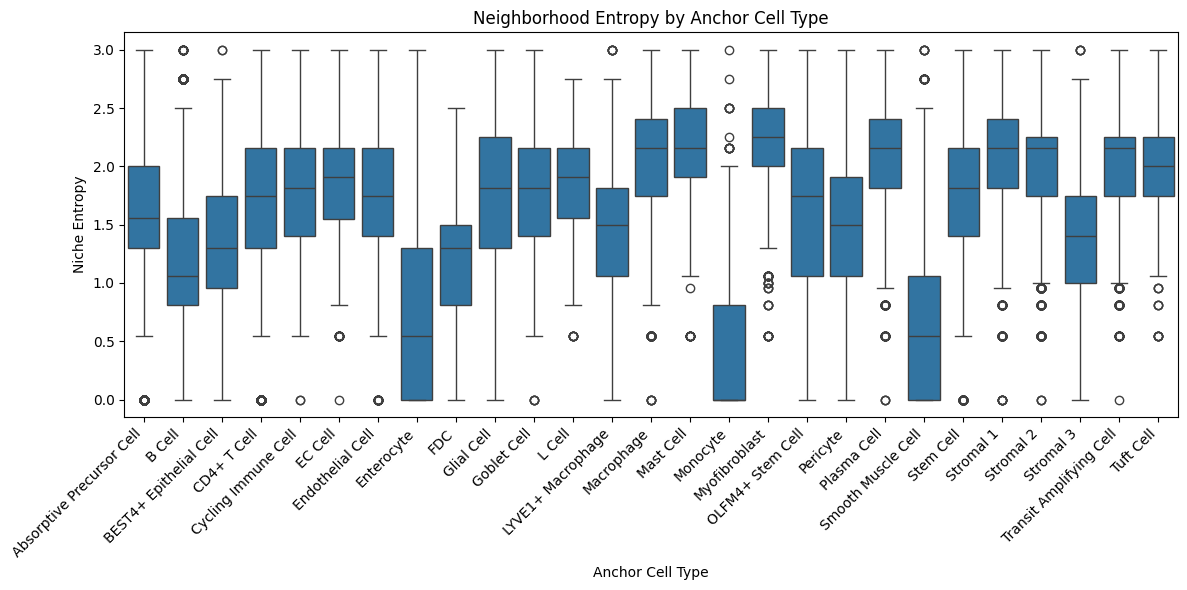

In [24]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=adata.obs, x='celltypist_label_cluster', y='niche_entropy')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Anchor Cell Type')
plt.ylabel('Niche Entropy')
plt.title('Neighborhood Entropy by Anchor Cell Type')
plt.tight_layout()
plt.show()

Remember to save your data when you're done.

In [25]:
adata.write_h5ad('../data_spatial/10x_colon_cell_celltyped_analysis.h5ad')

While not covered in this notebook, a common use of niches is to create an embedding using this information. Tools such as Wasserstein Wormhole (Haviv et al, [*ICML*](https://openreview.net/pdf?id=Su0qe33cWA) 2024, [ReadTheDocs](https://wassersteinwormhole.readthedocs.io/en/latest/)) take niches and embed them into a more interpretable space where common analyses such as diffusion components or differential expression can be applied. `NicheMats` would be an input to such a model. 